**Imports and Reading Dataset**

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


df = pd.read_csv("diabetes.csv")

**General Information About Dataset**

In [25]:
def information(df):
    print("###############################    Shape  ##################################")
    print(df.shape)
    print("###############################    Types  ##################################")
    print(df.dtypes)
    print("###############################    Head   ##################################")
    print(df.head())
    print("###############################    Tail   ##################################")
    print(df.tail())
    print("###############################    NA     ##################################")
    print(df.isnull().sum())
    print("############################### Quantiles ##################################")
    print(df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

information(df)

###############################    Shape  ##################################
(768, 9)
###############################    Types  ##################################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
###############################    Head   ##################################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35    

**Defining of Numerical and Categorical Variables**

In [26]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

cat_cols
num_cols
cat_but_car

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


[]

**Analysis of Categorical Variables**

In [27]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

cat_summary(df, "Outcome")

   Outcome  Ratio
0      500 65.104
1      268 34.896
##########################################


**Analysis of Numerical Variables**

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


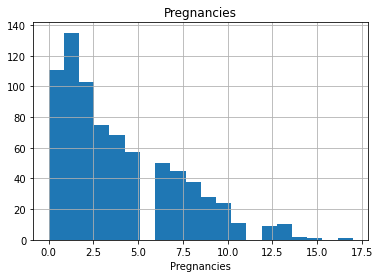

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


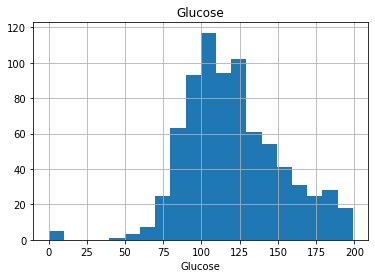

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


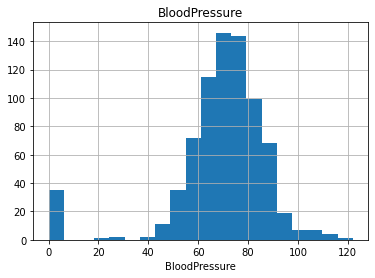

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


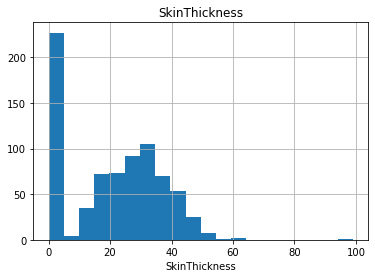

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


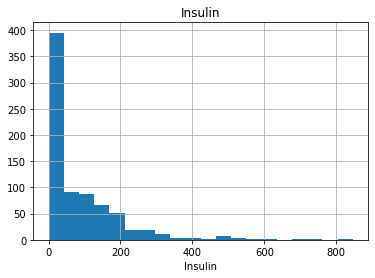

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


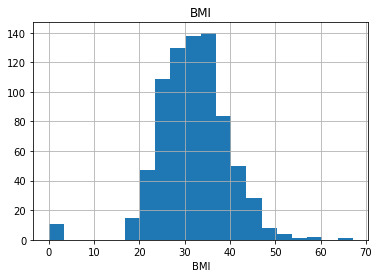

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


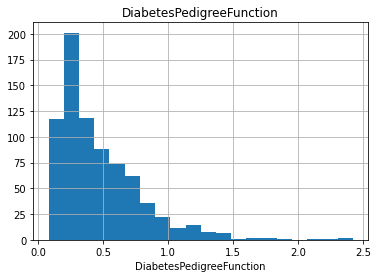

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


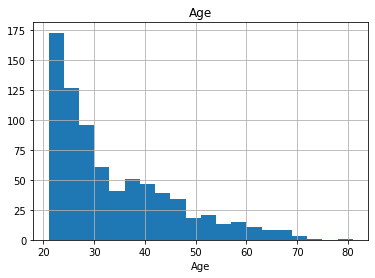

In [28]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

**Analysis of numerical variables according to target variable**

In [29]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




**Defining Outliers**

In [30]:
q1 = df["Glucose"].quantile(0.25)
q3 = df["Glucose"].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

df[(df["Glucose"] < low) | (df["Glucose"] > up)].any(axis=None)

True

In [31]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

outlier_thresholds(df, 'BloodPressure')
outlier_thresholds(df, 'Glucose')

(37.125, 202.125)

In [32]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

check_outlier(df, 'BloodPressure')
check_outlier(df, 'Glucose')

True

**Defining Missing Values**

In [33]:
df.isnull().values.any() #Is there any missing observation ?

False

In [34]:
df.isnull().sum() #number of missing values in variables

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [35]:
df.notnull().sum() #number of not missing values in variables

Pregnancies                 768
Glucose                     768
BloodPressure               768
SkinThickness               768
Insulin                     768
BMI                         768
DiabetesPedigreeFunction    768
Age                         768
Outcome                     768
dtype: int64

In [36]:
df.isnull().sum().sum() #total number of missing values in the data set

0

In [37]:
df[df.isnull().any(axis=1)] #observation units with at least one missing value

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [38]:
df[df.notnull().all(axis=1)] #complete observation units

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.900,0.171,63,0
764,2,122,70,27,0,36.800,0.340,27,0
765,5,121,72,23,112,26.200,0.245,30,0
766,1,126,60,0,0,30.100,0.349,47,1


**Correlation Analysis**

In [49]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


There seems to be a strong positive correlation between the variables 'Insulin' and 'SkinThickness'.

**Solving the missing value problem**

In [50]:
df.isnull().values.any()


False

It returns false because there are missing values ​​that show up as 0 but not 'NaN'.

In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


'Glucose', 'BloodPressure', 'SkinThickness' 'Insulin' and 'BMI' are variables that should not be zero.

In [52]:
missing_values = df[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]]

We have assigned these variables as 'missing_values', not to be confused with 'Pregnancies' and 'Outcome'
needs to change to 'NaN' for

In [54]:
for i in missing_values.columns:
    df.loc[(df[i] == 0), i] = np.NaN #Capture of missing values

In [55]:
na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]

In [57]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

missing_values_table(df, True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650
               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [58]:
# Solution 1: Quick delete

df.dropna().shape

(392, 9)

In [59]:
# Solution 2: Filling with Simple Assignment Methods

df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0).head()

dff = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)

dff.isnull().sum().sort_values(ascending=False)

df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0).isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [60]:
# Assigning Value in Categorical Variable Breakdown

df.groupby("Glucose")["Age"].mean()

df["Age"].mean()

df["Age"].fillna(df.groupby("Glucose")["Age"].transform("mean")).isnull().sum()

df.isnull().sum()


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [61]:
# Solution 3: Filling with Predictive Assignment

cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "Outcome"]
dff = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)

dff.head()

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,6,148.000,72.000,35.000,NaN,33.600,0.627,50
1,0,1,85.000,66.000,29.000,NaN,26.600,0.351,31
2,1,8,183.000,64.000,NaN,NaN,23.300,0.672,32
3,0,1,89.000,66.000,23.000,94.000,28.100,0.167,21
4,1,0,137.000,40.000,35.000,168.000,43.100,2.288,33


In [64]:
# standardization of variables

scaler = MinMaxScaler()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
dff.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.000,0.353,0.671,0.490,0.304,NaN,0.315,0.234,0.483
1,0.000,0.059,0.265,0.429,0.239,NaN,0.172,0.117,0.167
2,1.000,0.471,0.897,0.408,NaN,NaN,0.104,0.254,0.183
3,0.000,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000
4,1.000,0.000,0.600,0.163,0.304,0.185,0.509,0.944,0.200


In [65]:
# Implementation of knn.
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
df.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.000,0.353,0.671,0.490,0.304,0.385,0.315,0.234,0.483
1,0.000,0.059,0.265,0.429,0.239,0.051,0.172,0.117,0.167
2,1.000,0.471,0.897,0.408,0.274,0.269,0.104,0.254,0.183
3,0.000,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000
4,1.000,0.000,0.600,0.163,0.304,0.185,0.509,0.944,0.200


**Capture of Outliers**

In [66]:
# Accessing Outliers Themselves
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

grab_outliers(df, "BloodPressure")

grab_outliers(df, "BloodPressure", True)

BloodPressure_index = grab_outliers(df, "BloodPressure", True)


outlier_thresholds(df, "BloodPressure")
check_outlier(df, "BloodPressure")
grab_outliers(df, "BloodPressure", True)

     Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
18     0.000        0.059    0.381          0.061          0.337    0.083   
43     1.000        0.529    0.819          0.878          0.185    0.272   
84     1.000        0.294    0.600          0.857          0.378    0.252   
106    0.000        0.059    0.335          1.000          0.124    0.068   
125    1.000        0.059    0.284          0.061          0.380    0.102   

      BMI  DiabetesPedigreeFunction   Age  
18  0.513                     0.045 0.200  
43  0.556                     0.275 0.550  
84  0.626                     0.064 0.267  
106 0.086                     0.055 0.100  
125 0.753                     0.178 0.083  
     Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
18     0.000        0.059    0.381          0.061          0.337    0.083   
43     1.000        0.529    0.819          0.878          0.185    0.272   
84     1.000        0.294    0.600        

Int64Index([18, 43, 84, 106, 125, 177, 362, 549, 597, 599, 658, 662, 672, 691], dtype='int64')

**Solving the Outlier Problem**

In [67]:
# Delete

low, up = outlier_thresholds(df, "BloodPressure")

df.shape

(768, 9)

In [68]:
df[~((df["BloodPressure"] < low) | (df["BloodPressure"] > up))].shape

(754, 9)

In [69]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [70]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in "Outcome"]

df.shape

for col in num_cols:
    new_df = remove_outlier(df, col)

df.shape[0] - new_df.shape[0]

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


9

In [71]:
#Re-assignment with thresholds

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "Outcome"]

df.shape


Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


(768, 9)

In [72]:

for col in num_cols:
    print(col, check_outlier(df, col))

for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))


Pregnancies True
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True
Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


**Creating New Features**

In [83]:
df['Insulin_Level']=pd.cut(df['Insulin'], bins=[0, 100, 130,170], labels=['Low_Insulin', 'Normal_Insulin', 'High_Insulin'])

df.groupby('Insulin_Level').agg({'Outcome': ['mean', 'count']})

Outcome      
                  mean count
Insulin_Level               
Low_Insulin      0.348   767
Normal_Insulin     NaN     0
High_Insulin       NaN     0

In [81]:

df['Tension'] = pd.cut(df['BloodPressure'], bins=[0, 70, 90, 140],
                       labels=["Hipptension", "Normal_Tension", 'Hypertension'])

df.groupby('Tension').agg({'Outcome':['mean','count']})


Outcome      
                  mean count
Tension                     
Hipptension      0.349   768
Normal_Tension     NaN     0
Hypertension       NaN     0

**Encoding**

In [84]:
#Label Encoding

le = LabelEncoder()

le.fit_transform(df["Insulin_Level"])[0:5]

df['Insulin_Level'] = le.fit_transform(df['Insulin_Level'])

df.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Tension,Insulin_Level
0,1.000,0.353,0.671,0.490,0.304,0.385,0.315,0.234,0.483,Hipptension,0
1,0.000,0.059,0.265,0.429,0.239,0.051,0.172,0.117,0.167,Hipptension,0
2,1.000,0.471,0.897,0.408,0.274,0.269,0.104,0.254,0.183,Hipptension,0
3,0.000,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000,Hipptension,0
4,1.000,0.000,0.600,0.163,0.304,0.185,0.509,0.479,0.200,Hipptension,0


In [85]:
le.fit_transform(df["Tension"])[0:5]

df['Tension'] = le.fit_transform(df['Tension'])

df.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Tension,Insulin_Level
0,1.000,0.353,0.671,0.490,0.304,0.385,0.315,0.234,0.483,0,0
1,0.000,0.059,0.265,0.429,0.239,0.051,0.172,0.117,0.167,0,0
2,1.000,0.471,0.897,0.408,0.274,0.269,0.104,0.254,0.183,0,0
3,0.000,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000,0,0
4,1.000,0.000,0.600,0.163,0.304,0.185,0.509,0.479,0.200,0,0


In [86]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

df.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Tension,Insulin_Level
0,1.000,0.353,0.671,0.490,0.304,0.385,0.315,0.234,0.483,0,0
1,0.000,0.059,0.265,0.429,0.239,0.051,0.172,0.117,0.167,0,0
2,1.000,0.471,0.897,0.408,0.274,0.269,0.104,0.254,0.183,0,0
3,0.000,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000,0,0
4,1.000,0.000,0.600,0.163,0.304,0.185,0.509,0.479,0.200,0,0


In [88]:
#One-Hot Encoding

df["Tension"].value_counts()

pd.get_dummies(df, columns=["Tension"]).head()

pd.get_dummies(df, columns=["Tension"], drop_first=True).head()

pd.get_dummies(df, columns=["Tension"], dummy_na=True).head()

pd.get_dummies(df, columns=["Age", "Tension"], drop_first=True).head()

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

cat_cols, num_cols, cat_but_car = grab_col_names(df)

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

one_hot_encoder(df, ohe_cols).head()

df.head()


Observations: 768
Variables: 11
cat_cols: 3
num_cols: 8
cat_but_car: 0
num_but_cat: 3


,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Tension,Insulin_Level
0,1.000,0.353,0.671,0.490,0.304,0.385,0.315,0.234,0.483,0,0
1,0.000,0.059,0.265,0.429,0.239,0.051,0.172,0.117,0.167,0,0
2,1.000,0.471,0.897,0.408,0.274,0.269,0.104,0.254,0.183,0,0
3,0.000,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000,0,0
4,1.000,0.000,0.600,0.163,0.304,0.185,0.509,0.479,0.200,0,0


**Scaler**

In [89]:
# StandardScaler:

ss = StandardScaler()

df["Tension_s_scaler"] = ss.fit_transform(df[["Tension"]])

df.head()


,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Tension,Insulin_Level,Tension_s_scaler
0,1.000,0.353,0.671,0.490,0.304,0.385,0.315,0.234,0.483,0,0,0.000
1,0.000,0.059,0.265,0.429,0.239,0.051,0.172,0.117,0.167,0,0,0.000
2,1.000,0.471,0.897,0.408,0.274,0.269,0.104,0.254,0.183,0,0,0.000
3,0.000,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000,0,0,0.000
4,1.000,0.000,0.600,0.163,0.304,0.185,0.509,0.479,0.200,0,0,0.000


In [90]:
# RobustScaler:

rs = RobustScaler()

df["Tension_r_scaler"] = rs.fit_transform(df[["Tension"]])

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000
Pregnancies,768.000,0.226,0.197,0.000,0.059,0.176,0.353,0.794
Glucose,768.000,0.501,0.197,0.000,0.355,0.471,0.626,1.000
BloodPressure,768.000,0.493,0.120,0.163,0.408,0.490,0.571,0.816
SkinThickness,768.000,0.239,0.098,0.000,0.173,0.239,0.304,0.501
Insulin,768.000,0.161,0.095,0.000,0.090,0.139,0.210,0.390
BMI,768.000,0.290,0.137,0.000,0.188,0.285,0.376,0.658
DiabetesPedigreeFunction,768.000,0.163,0.122,0.000,0.071,0.126,0.234,0.479
Age,768.000,0.203,0.194,0.000,0.050,0.133,0.333,0.758
Tension,768.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [92]:
# MinMaxScaler:

mms = MinMaxScaler()

df["Tensin_m.m_scaler"] = mms.fit_transform(df[["Tension"]])

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000
Pregnancies,768.000,0.226,0.197,0.000,0.059,0.176,0.353,0.794
Glucose,768.000,0.501,0.197,0.000,0.355,0.471,0.626,1.000
BloodPressure,768.000,0.493,0.120,0.163,0.408,0.490,0.571,0.816
SkinThickness,768.000,0.239,0.098,0.000,0.173,0.239,0.304,0.501
Insulin,768.000,0.161,0.095,0.000,0.090,0.139,0.210,0.390
BMI,768.000,0.290,0.137,0.000,0.188,0.285,0.376,0.658
DiabetesPedigreeFunction,768.000,0.163,0.122,0.000,0.071,0.126,0.234,0.479
Age,768.000,0.203,0.194,0.000,0.050,0.133,0.333,0.758
Tension,768.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [93]:
df.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Tension,Insulin_Level,Tension_s_scaler,Tension_r_scaler,Tensin_m.m_scaler
0,1.000,0.353,0.671,0.490,0.304,0.385,0.315,0.234,0.483,0,0,0.000,0.000,0.000
1,0.000,0.059,0.265,0.429,0.239,0.051,0.172,0.117,0.167,0,0,0.000,0.000,0.000
2,1.000,0.471,0.897,0.408,0.274,0.269,0.104,0.254,0.183,0,0,0.000,0.000,0.000
3,0.000,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000,0,0,0.000,0.000,0.000
4,1.000,0.000,0.600,0.163,0.304,0.185,0.509,0.479,0.200,0,0,0.000,0.000,0.000


**Creating Model**

In [94]:
y = df["Outcome"]
X = df.drop(["Outcome", "Age"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)


0.7835497835497836